In [1]:
!pip install -U accelerate
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from transformers import Trainer, AutoModelForSequenceClassification, logging
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import evaluate
import warnings
import wandb

logging.set_verbosity_warning()
logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv("clean.csv")
df.rename(columns={"text_clean": "text", "polarity": "label"}, inplace=True)
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)

df = df[['text', 'label']]
df.sample(5)

,text,label
4264,menang tugas banget deadline ngotak pantengin ...,negative
4572,bamsat kuliah onlen emange protes tanda emang ...,negative
2299,allah cape banget kuliah onlen,positive
3880,sadar engga kuliah onlen whatsapp grup pantau ...,negative
6588,jarang suda mulai kuliah onlen,neutral


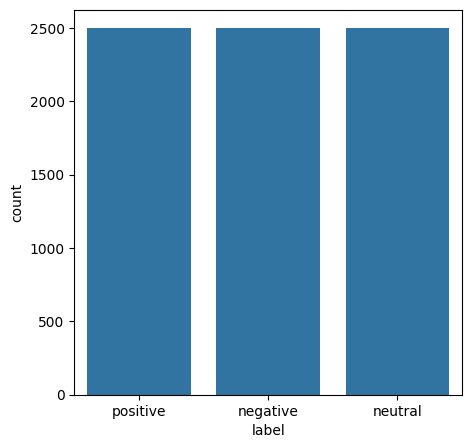

In [4]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df['label'])
plt.show()

In [5]:
df["label"] = df["label"].map({"negative": 0, "neutral": 1, "positive": 2})

In [6]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.1,
    random_state=RANDOM_SEED,
)


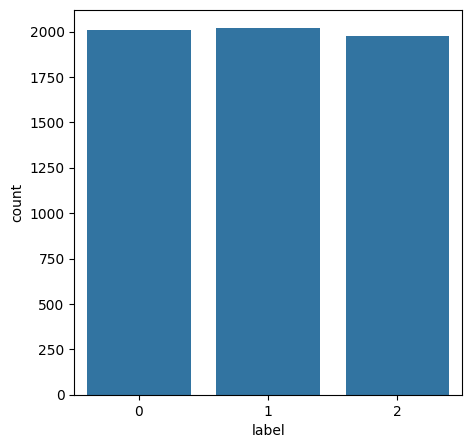

In [7]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_train['label'])
plt.show()

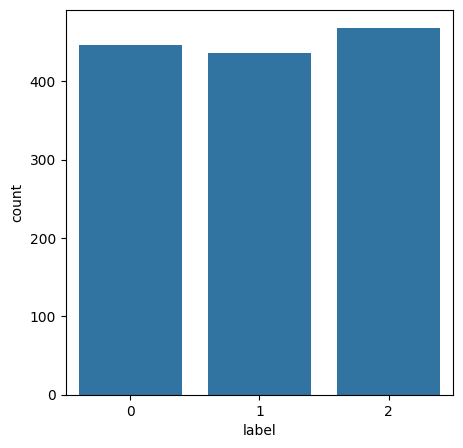

In [8]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_val['label'])
plt.show()

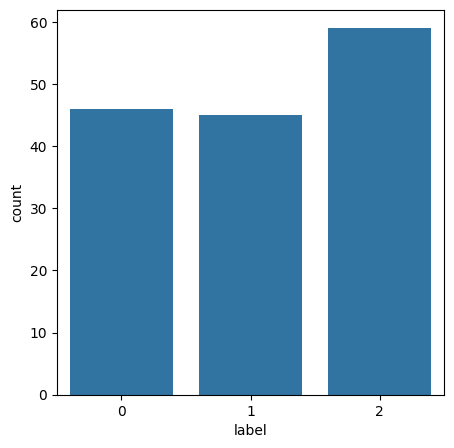

In [9]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_test['label'])
plt.show()

In [10]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 6000
Total Val  : 1350
Total Test : 150


In [11]:
actual_label = df_test['label']

In [12]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [13]:
# Load CSV files into pandas DataFrames
df_train = pd.read_csv("train.csv")
df_eval = pd.read_csv("eval.csv")
df_test = pd.read_csv("test.csv")

In [14]:
from datasets import Dataset, DatasetDict
import pandas as pd

# Convert pandas DataFrames to Dataset objects
train_dataset = Dataset.from_pandas(df_train)
eval_dataset = Dataset.from_pandas(df_eval)
test_dataset = Dataset.from_pandas(df_test)

# Create a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "eval": eval_dataset,
    "test": test_dataset,
})

### **Tokenize Model**

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [17]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

### **Train Model**

In [18]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [19]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [20]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "trainer_sentiboard_indobert_bs24_ml256",
    eval_strategy="steps",
    per_device_train_batch_size=24,
    log_level='info',
    logging_dir='./logs',             # Directory for logging
    logging_steps=50,                 # Log every 50 steps
    save_steps=100                    # Save checkpoint every 100 steps
)

In [21]:
# Initialize an empty list to store the results
metric_result = []

# Define the compute metrics function
def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"]
    metric = {met: evaluate.load(met) for met in metrics}
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metric_res = {}
    for met in metrics:
        if met == 'accuracy':
            metric_res[met] = metric[met].compute(predictions=predictions, references=labels)[met]
        else:
            metric_res[met] = metric[met].compute(predictions=predictions, references=labels, average="weighted")[met]

    metric_result.append(metric_res)
    return metric_res

In [22]:
torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

Safetensors PR exists
The following columns in the Training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

***** Running training *****
  Num examples = 6,000
  Num Epochs = 3
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 750
  Number of trainable parameters = 124,443,651
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kurniadiahmadwijaya (kurniadiahmadwijaya-bank-btpn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.6499, 'grad_norm': 8.413052558898926, 'learning_rate': 4.6733333333333335e-05, 'epoch': 0.2}


{'eval_loss': 0.6296156048774719, 'eval_accuracy': 0.7896296296296297, 'eval_recall': 0.7896296296296297, 'eval_precision': 0.811743938119766, 'eval_f1': 0.7859991391277638, 'eval_runtime': 26.4474, 'eval_samples_per_second': 51.045, 'eval_steps_per_second': 6.39, 'epoch': 0.2}


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.4814, 'grad_norm': 10.660346031188965, 'learning_rate': 4.3400000000000005e-05, 'epoch': 0.4}


Saving model checkpoint to trainer_sentiboard_indobert_bs24_ml256/checkpoint-100
Configuration saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-100/config.json


{'eval_loss': 0.4854692816734314, 'eval_accuracy': 0.8422222222222222, 'eval_recall': 0.8422222222222222, 'eval_precision': 0.8458598307016156, 'eval_f1': 0.840510242976457, 'eval_runtime': 24.825, 'eval_samples_per_second': 54.381, 'eval_steps_per_second': 6.808, 'epoch': 0.4}


Model weights saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-100/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.4277, 'grad_norm': 6.037622928619385, 'learning_rate': 4.006666666666667e-05, 'epoch': 0.6}
{'eval_loss': 0.4339514970779419, 'eval_accuracy': 0.8451851851851852, 'eval_recall': 0.8451851851851852, 'eval_precision': 0.8501164649546216, 'eval_f1': 0.8432073813241053, 'eval_runtime': 24.8251, 'eval_samples_per_second': 54.38, 'eval_steps_per_second': 6.808, 'epoch': 0.6}


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.3788, 'grad_norm': 7.666097164154053, 'learning_rate': 3.6733333333333336e-05, 'epoch': 0.8}


Saving model checkpoint to trainer_sentiboard_indobert_bs24_ml256/checkpoint-200
Configuration saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-200/config.json


{'eval_loss': 0.3690524697303772, 'eval_accuracy': 0.8562962962962963, 'eval_recall': 0.8562962962962963, 'eval_precision': 0.8566347448936598, 'eval_f1': 0.8545277570723254, 'eval_runtime': 24.9757, 'eval_samples_per_second': 54.053, 'eval_steps_per_second': 6.767, 'epoch': 0.8}


Model weights saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-200/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.3675, 'grad_norm': 12.404662132263184, 'learning_rate': 3.3400000000000005e-05, 'epoch': 1.0}
{'eval_loss': 0.4483318328857422, 'eval_accuracy': 0.8518518518518519, 'eval_recall': 0.8518518518518519, 'eval_precision': 0.8700979420979421, 'eval_f1': 0.8533746362034713, 'eval_runtime': 24.7257, 'eval_samples_per_second': 54.599, 'eval_steps_per_second': 6.835, 'epoch': 1.0}


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.2573, 'grad_norm': 8.951796531677246, 'learning_rate': 3.006666666666667e-05, 'epoch': 1.2}


Saving model checkpoint to trainer_sentiboard_indobert_bs24_ml256/checkpoint-300
Configuration saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-300/config.json


{'eval_loss': 0.44092443585395813, 'eval_accuracy': 0.837037037037037, 'eval_recall': 0.837037037037037, 'eval_precision': 0.8472263523090136, 'eval_f1': 0.8335229022727744, 'eval_runtime': 24.9067, 'eval_samples_per_second': 54.202, 'eval_steps_per_second': 6.785, 'epoch': 1.2}


Model weights saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-300/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.2755, 'grad_norm': 2.7205350399017334, 'learning_rate': 2.6733333333333334e-05, 'epoch': 1.4}
{'eval_loss': 0.3284936547279358, 'eval_accuracy': 0.8888888888888888, 'eval_recall': 0.8888888888888888, 'eval_precision': 0.8883862520763535, 'eval_f1': 0.8882945375271531, 'eval_runtime': 24.8989, 'eval_samples_per_second': 54.219, 'eval_steps_per_second': 6.787, 'epoch': 1.4}


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.2489, 'grad_norm': 5.095343112945557, 'learning_rate': 2.3400000000000003e-05, 'epoch': 1.6}


Saving model checkpoint to trainer_sentiboard_indobert_bs24_ml256/checkpoint-400
Configuration saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-400/config.json


{'eval_loss': 0.336315780878067, 'eval_accuracy': 0.8814814814814815, 'eval_recall': 0.8814814814814815, 'eval_precision': 0.8829201084581147, 'eval_f1': 0.881443471629001, 'eval_runtime': 25.5821, 'eval_samples_per_second': 52.771, 'eval_steps_per_second': 6.606, 'epoch': 1.6}


Model weights saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-400/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.1941, 'grad_norm': 4.711963653564453, 'learning_rate': 2.0066666666666665e-05, 'epoch': 1.8}
{'eval_loss': 0.3356584906578064, 'eval_accuracy': 0.8859259259259259, 'eval_recall': 0.8859259259259259, 'eval_precision': 0.8858505716188068, 'eval_f1': 0.8858832194445734, 'eval_runtime': 24.7681, 'eval_samples_per_second': 54.506, 'eval_steps_per_second': 6.823, 'epoch': 1.8}


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.2389, 'grad_norm': 8.190475463867188, 'learning_rate': 1.6733333333333335e-05, 'epoch': 2.0}


Saving model checkpoint to trainer_sentiboard_indobert_bs24_ml256/checkpoint-500
Configuration saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-500/config.json


{'eval_loss': 0.3308568298816681, 'eval_accuracy': 0.8925925925925926, 'eval_recall': 0.8925925925925926, 'eval_precision': 0.8941199139870517, 'eval_f1': 0.8919297510686779, 'eval_runtime': 24.947, 'eval_samples_per_second': 54.115, 'eval_steps_per_second': 6.774, 'epoch': 2.0}


Model weights saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-500/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.1465, 'grad_norm': 7.689798831939697, 'learning_rate': 1.3400000000000002e-05, 'epoch': 2.2}
{'eval_loss': 0.36768823862075806, 'eval_accuracy': 0.8955555555555555, 'eval_recall': 0.8955555555555555, 'eval_precision': 0.8953525991130368, 'eval_f1': 0.8951745298479258, 'eval_runtime': 25.1545, 'eval_samples_per_second': 53.668, 'eval_steps_per_second': 6.718, 'epoch': 2.2}


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.0977, 'grad_norm': 2.9958114624023438, 'learning_rate': 1.0066666666666668e-05, 'epoch': 2.4}


Saving model checkpoint to trainer_sentiboard_indobert_bs24_ml256/checkpoint-600
Configuration saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-600/config.json


{'eval_loss': 0.4008106291294098, 'eval_accuracy': 0.8970370370370371, 'eval_recall': 0.8970370370370371, 'eval_precision': 0.8971822718213285, 'eval_f1': 0.8968504166352017, 'eval_runtime': 25.5184, 'eval_samples_per_second': 52.903, 'eval_steps_per_second': 6.623, 'epoch': 2.4}


Model weights saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-600/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.1381, 'grad_norm': 4.990004062652588, 'learning_rate': 6.733333333333333e-06, 'epoch': 2.6}
{'eval_loss': 0.41435909271240234, 'eval_accuracy': 0.8896296296296297, 'eval_recall': 0.8896296296296297, 'eval_precision': 0.8892187900557078, 'eval_f1': 0.8891096218188179, 'eval_runtime': 24.8003, 'eval_samples_per_second': 54.435, 'eval_steps_per_second': 6.814, 'epoch': 2.6}


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.146, 'grad_norm': 13.242149353027344, 'learning_rate': 3.4000000000000005e-06, 'epoch': 2.8}


Saving model checkpoint to trainer_sentiboard_indobert_bs24_ml256/checkpoint-700
Configuration saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-700/config.json


{'eval_loss': 0.398567259311676, 'eval_accuracy': 0.882962962962963, 'eval_recall': 0.882962962962963, 'eval_precision': 0.8852131842981517, 'eval_f1': 0.8837800050917226, 'eval_runtime': 25.3398, 'eval_samples_per_second': 53.276, 'eval_steps_per_second': 6.669, 'epoch': 2.8}


Model weights saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-700/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'loss': 0.0961, 'grad_norm': 14.405405044555664, 'learning_rate': 6.666666666666667e-08, 'epoch': 3.0}


Saving model checkpoint to trainer_sentiboard_indobert_bs24_ml256/checkpoint-750
Configuration saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-750/config.json


{'eval_loss': 0.3975439965724945, 'eval_accuracy': 0.8918518518518519, 'eval_recall': 0.8918518518518519, 'eval_precision': 0.8924432001043584, 'eval_f1': 0.8921147665272452, 'eval_runtime': 24.7438, 'eval_samples_per_second': 54.559, 'eval_steps_per_second': 6.83, 'epoch': 3.0}


Model weights saved in trainer_sentiboard_indobert_bs24_ml256/checkpoint-750/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 1433.5813, 'train_samples_per_second': 12.556, 'train_steps_per_second': 0.523, 'train_loss': 0.2762903887430827, 'epoch': 3.0}


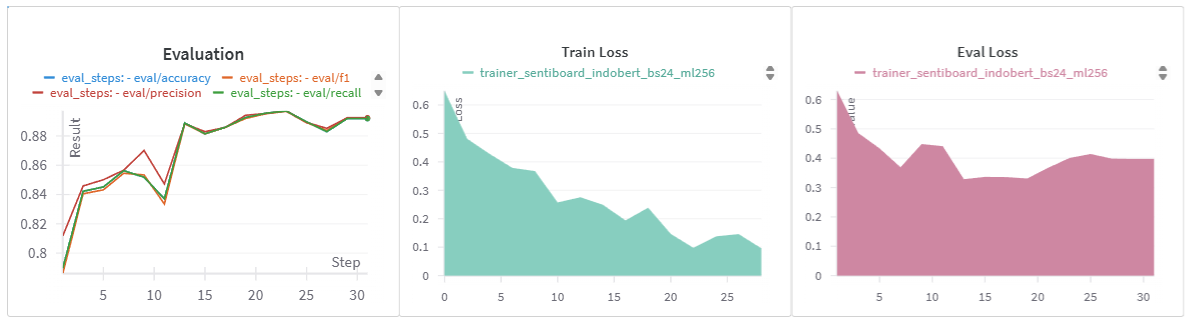

### **Evaluate Model**

In [23]:
evaluation_history = trainer.evaluate()
evaluation_history

The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8


{'eval_loss': 0.3975439965724945, 'eval_accuracy': 0.8918518518518519, 'eval_recall': 0.8918518518518519, 'eval_precision': 0.8924432001043584, 'eval_f1': 0.8921147665272452, 'eval_runtime': 24.5474, 'eval_samples_per_second': 54.996, 'eval_steps_per_second': 6.885, 'epoch': 3.0}


{'eval_loss': 0.3975439965724945,
 'eval_accuracy': 0.8918518518518519,
 'eval_recall': 0.8918518518518519,
 'eval_precision': 0.8924432001043584,
 'eval_f1': 0.8921147665272452,
 'eval_runtime': 24.5474,
 'eval_samples_per_second': 54.996,
 'eval_steps_per_second': 6.885,
 'epoch': 3.0}

In [24]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 150
  Batch size = 8


In [25]:
print(classification_report(prediction, actual_label, target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.93      0.93      0.93        46
      Netral       0.80      0.84      0.82        43
     Positif       0.90      0.87      0.88        61

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150



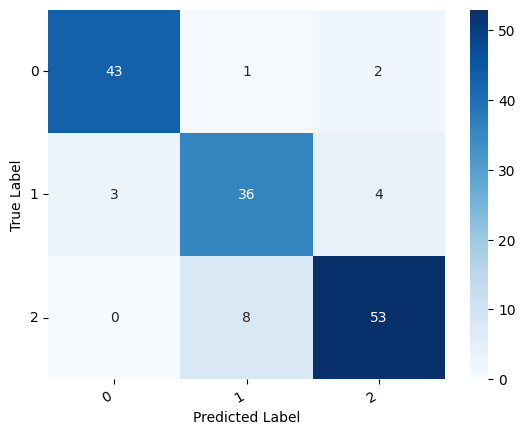

In [26]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

### **Save And Load Model**

In [27]:
model.save_pretrained("model")

Configuration saved in model/config.json
Model weights saved in model/model.safetensors


In [28]:
model = AutoModelForSequenceClassification.from_pretrained("model")

loading configuration file model/config.json
Model config BertConfig {
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float3

In [29]:
trainer = Trainer(model=model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [30]:
def predict(text):
    tokenized = tokenizer(text, padding='max_length', max_length=256)
    label = trainer.predict([tokenized]).predictions.argmax(1)[0]
    if label == 0:
        print(f'Predicted: Negatif [{label}]')
    elif label == 1:
        print(f'Predicted: Netral [{label}]')
    else:
        print(f'Predicted: Positif [{label}]')


In [31]:
predict("""
    universitas telkom mahal banget bayar bpp full
    padahal kuliah online gak dikembalikan duitnya
""")


***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Predicted: Negatif [0]


In [32]:
predict("saya senang sekali kuliah di universitas telkom")


***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Positif [2]


In [33]:
predict("kuliah online di tel-u enak-enak aja kok")


***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Netral [1]


In [34]:
from huggingface_hub import notebook_login
notebook_login()

## **Publish To HuggingFace**

[ShinyQ/indobert-sentiment-analysis-indonesian-university-reviews](https://huggingface.co/ShinyQ/indobert-sentiment-analysis-indonesian-university-reviews)

In [35]:
model.push_to_hub("ShinyQ/indobert-sentiment-analysis-indonesian-university-reviews")

README.md:   0%|          | 0.00/4.05k [00:00<?, ?B/s]

Configuration saved in /tmp/tmp85wkvha7/config.json
Model weights saved in /tmp/tmp85wkvha7/model.safetensors
Uploading the following files to ShinyQ/indobert-sentiment-analysis-indonesian-university-reviews: model.safetensors,config.json,README.md


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ShinyQ/indobert-sentiment-analysis-indonesian-university-reviews/commit/dde4f772dbbccaa266a183c4784f5c6a79242c3b', commit_message='Upload BertForSequenceClassification', commit_description='', oid='dde4f772dbbccaa266a183c4784f5c6a79242c3b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ShinyQ/indobert-sentiment-analysis-indonesian-university-reviews', endpoint='https://huggingface.co', repo_type='model', repo_id='ShinyQ/indobert-sentiment-analysis-indonesian-university-reviews'), pr_revision=None, pr_num=None)